In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
# display the first rows columns and data in a dictionary format
first_row_M = session.query(Measurement).first()
first_row_M.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1e53554f700>,
 'station': 'USC00519397',
 'date': '2010-01-01',
 'tobs': 65.0,
 'id': 1,
 'prcp': 0.08}

In [10]:
# display the first rows columns and data in a dictionary format
first_row_S = session.query(Station).first()
first_row_S.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1e53554e6e0>,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'latitude': 21.2716,
 'id': 1,
 'station': 'USC00519397',
 'elevation': 3.0}

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
recent = session.query(Measurement).order_by(Measurement.date.desc()).first()
recent.date

'2017-08-23'

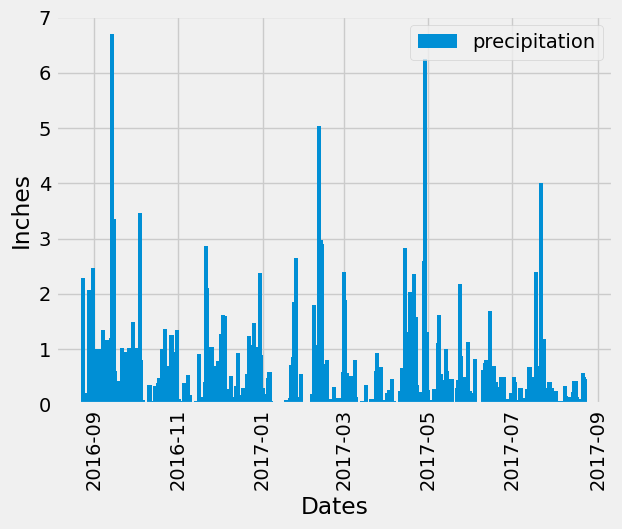

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
from datetime import timedelta, datetime as dt
most_recent_entry = dt.strptime(recent.date,'%Y-%m-%d')
year_ago = (most_recent_entry - timedelta(days=365)).strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
last_year = session.query(Measurement).\
    filter(Measurement.date > year_ago)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
last_year_df = pd.read_sql(last_year.statement, last_year.session.bind)

# Sort the dataframe by date
prcp_df = last_year_df[['date', 'prcp']].sort_values('date', ascending=True).reset_index(drop=True)

# Replace NA values with 0 for percipitation
#prcp_df[['prcp']].fillna(0, inplace=True)

# Change date type from object to datetime
prcp_df['date'] = prcp_df['date'].values.astype("datetime64")

# Use Pandas Plotting with Matplotlib to plot the data
bar = plt.bar(prcp_df['date'],prcp_df['prcp'], width=3)
plt.xlabel('Dates')
plt.xticks(rotation=90)
plt.ylabel('Inches')
plt.legend(['precipitation'])
plt.show()


In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_prcp = last_year_df[['prcp']].rename(columns={'prcp':'percipitation'}).describe()
summary_prcp

,percipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [24]:
stations_df = pd.read_sql(session.query(Station).statement, session.bind)
stations_df

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [25]:
# Design a query to calculate the total number of stations in the dataset
from sqlalchemy import distinct
station_count = session.query(func.count(distinct(Measurement.station))).scalar()
station_count

9

In [30]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
stations_counts = session.query(*[Measurement.station, func.count(Measurement.id)]).\
    group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()
stations_counts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [32]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = session.query(*[func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).first()
most_active

(54.0, 85.0, 71.66378066378067)

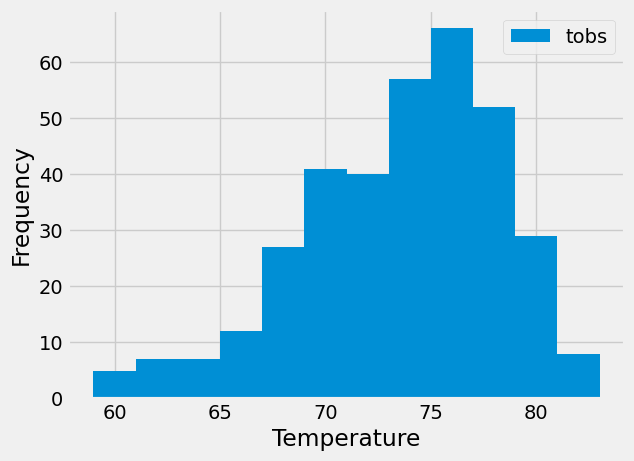

In [45]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Get most active station 
most_active_station = stations_counts[0][0]

# Query data for station for the past year
most_active_station_data = session.query(Measurement).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date > year_ago)

# Save the data to a dataframe
most_active_df = pd.read_sql(most_active_station_data.statement, most_active_station_data.session.bind)

# Use Pandas Plotting with Matplotlib to plot the data
hist = plt.hist(most_active_df['tobs'], bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(['tobs'])
plt.show()

# Close Session

In [46]:
# Close Session
session.close()